Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH = "./"  # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive

    drive.mount("/content/drive")

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
else:
    import sys

    sys.path.insert(0, "..")
    import os

    PATH = "../"
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint

# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

# Generate, load and save the dataset

In [4]:
device = set_device()
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)

utype = None  #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 1.5
u_func.params["f0"] = 0
u_func.params["f1"] = 4  # 4 # 1.4
u_func.params["scale"] = 0.001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = "simple"
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 300
num_trajectories = 10
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]

train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=False,
    num_trajectories=num_trajectories,
    coord_type="hamiltonian",
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
)

cpu


torch.Size([10, 300, 4])
q1 torch.Size([300])
energy torch.Size([300])


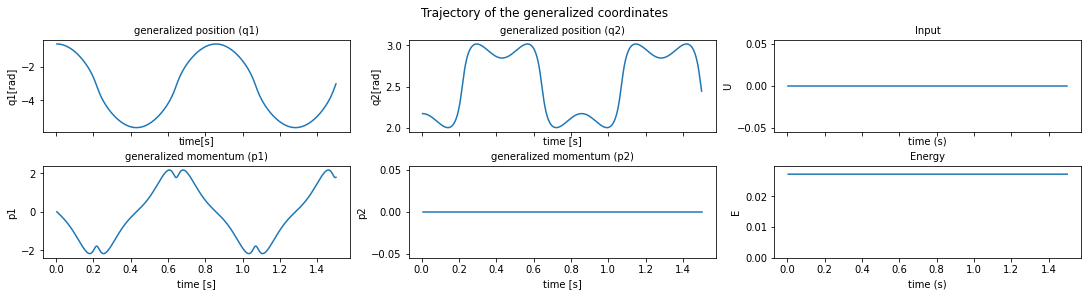

In [5]:
x, t = next(iter(train_loader))
print(x.shape)
for n in range(1):
    t_eval = t[0, :].cpu().detach()
    q1 = x[n, :, 0].cpu().detach()
    p1 = x[n, :, 1].cpu().detach()
    q2 = x[n, :, 2].cpu().detach()
    p2 = x[n, :, 3].cpu().detach()

    u = u_func.forward(t_eval).cpu().detach()
    G = g_func.forward(x[n, :, :4]).cpu().detach()
    energy, derivatives = get_energy_furuta(
        device,
        time_steps,
        Ts,
        u_func,
        g_func,
        q1 / w_rescale[0],
        p1 / w_rescale[1],
        q2 / w_rescale[2],
        p2 / w_rescale[3],
        C_q1,
        C_q2,
        g,
        Jr,
        Lr,
        Mp,
        Lp,
    )
    print("q1", q1.shape)
    print("energy", energy.shape)
    energy = energy.detach().squeeze()

    plot_traj_furuta_withinput(
        t_eval,
        q1,
        p1,
        q2,
        p2,
        energy=energy,
        input=u,
        title="Trajectory of the generalized coordinates",
        coord_type="hamiltonian",
    )